In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.psd import interpolate, inverse_spectrum_truncation
import sys
#import xml.etree.ElementTree as ET
#from io import StringIO
from pycbc.waveform.bank import TemplateBank
from pycbc.types import TimeSeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [3]:
inj_time = 13

approximant = 'IMRPhenomD'

def get_chirp_mass(m1, m2):
    '''Calculate chirp mass'''
    chrp_mass = ((m1*m2)**(3/5))/((m1 + m2)**(1/5))
    return chrp_mass

def get_masses(m_chirp, m_ratio):
    mass1 = (m_ratio**(2/5))*((1 + m_ratio)**(1/5))*m_chirp
    mass2 = ((1 + m_ratio)**(1/5))*m_chirp/((m_ratio)**(3/5))
    return mass1, mass2

cmass_arr, q_arr = np.loadtxt(fname='injection.txt', unpack=True)

m1_arr, m2_arr = get_masses(cmass_arr, q_arr)

mass1_arr, mass2_arr = [], []
for m1, m2 in zip(m1_arr, m2_arr):
    if (20 <= m1 <= 60) and (20 <= m2 <= 60):
        mass1_arr.append(m1)
        mass2_arr.append(m2)

mass1_arr = mass1_arr[:200]
mass2_arr = mass2_arr[:200]



# tbank = TemplateBank('999mat1580D.xml.gz')

# mass1_bank, mass2_bank = [], []
# temp_bank = np.zeros((len(tbank.table['mass1']), 2))

# for i in range(len(tbank.table['mass1'])):
#     temp_bank[i, :] = [tbank.table['mass1'][i], tbank.table['mass2'][i]]



def gen_template_bank(m_1, m_2, m_radius, temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))

    for i in range(temp_numb):
        r1 = np.random.uniform(0, m_radius)
        r2 = np.random.uniform(0, (np.pi*2))
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1, m_2]

    return temp_bank

def MF_bank(ts, bank, psd1, show_fig=False, xmin1=0, xmax1=1):
    # this function performs matched filter on a time series with a bank of templates and returns the list of SNR time series

    for i, _ in enumerate(bank):
        print(f'Computing SNR for template {i+1}/{len(bank)}')
        # compute the SNR time series
        bank[i]['snr'],_, bank[i]['tpeak'], _, _, bank[i]['csnr_peak'] = gen_SNR(bank[i]['template'], ts, psd1,bank[i]['m1'],bank[i]['m2'])
        if show_fig:
            pp.figure(figsize=(15,3))
            abs(bank[i]['snr']).plot()
            pp.title(f"SNR for template {bank[i]['m1']:.1f},{bank[i]['m2']:.1f}")
            pp.xlim(xmin1, xmax1)
            pp.show()

    return bank

def best_trig(result):
    """
    Find the best trigger in a list of triggers.
    """
    maxSNR = 0
    for i, t in enumerate(result):
        if abs(t['csnr_peak']) > maxSNR:
            maxSNR = abs(t['csnr_peak'])
            maxIndex = i

    return maxIndex

def gen_noise(duration=64):

    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(duration/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples, delta_t, psd, seed=127)

    return ts, psd

def preprocess_bank(bank, N, psd1=None, flow=30, approximant='IMRPhenomD'):

    new_bank = []
    for i, t in enumerate(bank):
        # print(t)
        h1 = gen_waveform(approximant, t[0], t[1], 0, 0, 50, 0)

        h1.resize(N)
        h1 = h1.cyclic_time_shift(h1.sample_times[-1])
        sig1 = sigma(h1, psd=psd1, low_frequency_cutoff=flow)
        h1.data /= sig1
        # self_inner, _, _, _, _ = gen_SNR(h1, h1, psd1)

        new_bank.append({'m1': t[0], 'm2': t[1], 'template': h1})
        print(f'preprocess bank loop {i+1}/{len(bank)}')
    return new_bank

def find_peak(snr, mask_between=None):

    if mask_between is not None:
        mask = (snr.sample_times >= mask_between[0]) & (snr.sample_times < mask_between[1])
        snr1 = snr.copy()
        snr1.data[mask] = 0
    else:
        snr1 = snr

    peak = abs(snr1).numpy().argmax()
    snrp = abs(snr1[peak])
    csnrp = snr1[peak]
    tpeak = snr1.sample_times[peak]

    return tpeak, peak, snrp, csnrp

def gen_SNR(template, data, psd,m1,m2):

    snr = matched_filter(template, data,
                         psd=psd, low_frequency_cutoff=30)

    chisq_vals = gen_chisquare(template,data,m1,m2,0,0,psd)
    new_snr = newsnr(abs(snr),chisq_vals)
    nsnr = TimeSeries(np.array(new_snr),delta_t = snr.delta_t)
    
    
    tpeak, peak, snrp,_ = find_peak(nsnr)
    csnrp = snr[peak]

    return snr,nsnr,tpeak, peak, snrp, csnrp

def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):

    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)

    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2

    return chisq

def gen_waveform(model, m1, m2, s1z, s2z, distance, time):

    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2, spin1z=s1z, spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
        #print(f'ht1 ht2 order of injection')
    else:
        ht_small, ht_big = ht_2, ht_1
        #print(f'ht2 ht1 order of injection')
    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total, ht_2

def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.5*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total = ht_total.cyclic_time_shift(ht_total.start_time + injtime)
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    return ts

def shift_timeseries(tsx, tau):

    if 'float' in str(tsx.dtype):
        tsx_shifted = tsx.cyclic_time_shift(tau-tsx.duration)

    elif 'complex' in str(tsx.dtype):
        tsx_shifted_r = tsx.real().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted_i = tsx.imag().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted = tsx_shifted_r + 1j * tsx_shifted_i

    tsx_shifted.start_time = 0

    return tsx_shifted

def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)

    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

    ht_template = fp * hp + fc * hc
    ht_template.resize(len(conditioned))
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)

    return template

def match_other_best_template_simple(itrig1, bank, psd, width=0.15, show_figs=False):
    rho_N = bank[itrig1]['snr']
    h1_bns = bank[itrig1]['template']
    tpeak = bank[itrig1]['tpeak']
    snr_peak_N = abs(bank[itrig1]['csnr_peak'])
    xmin, xmax = tpeak-0.5, tpeak+0.5
    max_snr = 0
    buffer = 0

    for i, t in enumerate(bank):

        # print(f"({t['m1']}, {t['m2']})")
        rho_B = t['snr']
        h1_bbh = t['template']
        m1 = t['m1']
        m2 = t['m2']
        # if show_figs:
        #     pp.figure(figsize=(15, 3))
        #     abs(rho_B).plot()
        #     abs(rho_N).plot()
        #     pp.xlim(xmin, xmax)
            # pp.show()
        #print(f'Computing inner product for template {i+1}/{len(bank)}')
        x_nb,_,_, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd,m1,m2)
        shifted_nb = shift_timeseries(x_nb, tpeak)

        rho_sub = rho_B - snr_peak_N * shifted_nb

        # chisq_vals = gen_chisquare(h1_bbh, ?, t["m1"], t["m2"], 0, 0, psd)
        # new_snr = newsnr(abs(rho_sub), chisq_vals)

#         tpeak2, _, snrp, csnrp = find_peak(rho_sub) #, mask_between=(tpeak-width, tpeak+width)
        chisq_vals = gen_chisquare(h1_bbh,abs(rho_sub),m1,m2,0,0,psd)
        rho_sub_new = newsnr(abs(rho_sub),chisq_vals)
        rho_sub_new = TimeSeries(np.array(rho_sub_new),delta_t = rho_sub.delta_t)
    
        tpeak2, _, snrp, csnrp = find_peak(rho_sub_new)
        
        
        bank[i]['csnr_peak'] = csnrp
        bank[i]['tpeak'] = tpeak2

        if snrp > max_snr:
            itrig2 = i
            max_snr = snrp
            tpeak2_best = tpeak2
            shifted_nb_best = shifted_nb
            rho_sub_best = rho_sub
            buffer_best = buffer
            rho_b_best = rho_B

            if show_figs:
                print(f"({t['m1']}, {t['m2']}) {snrp} {tpeak2} {buffer}")
                pp.figure(figsize=(15, 6))
                pp.subplot(311)
                pp.title(f"peak {snr_peak_N:.2f}")
                abs(rho_B).plot()
                # abs(rho_N).plot()
                abs(rho_sub).plot()
                # (rho_sub).plot()
                pp.xlim(xmin, xmax)
                pp.subplot(312)
                abs(snr_peak_N * shifted_nb).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.subplot(313)
                abs(rho_sub).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.show()
    
    # pp.figure(figsize=(18,6))
    # pp.subplot(311)
    # pp.plot(shifted_nb_best.sample_times, max_snr*shifted_nb_best.real(), label='real(shifted_nb_best)*SNR')
    # pp.plot(rho_b_best.sample_times, rho_b_best.real(), label='real(rho_b_best)')
    # pp.legend(loc='upper left')
    # pp.xlim(11, 13.5)

    # pp.subplot(312)
    # pp.plot(shifted_nb_best.sample_times, max_snr*shifted_nb_best.imag(), label='imag(shifted_nb_best)*SNR')
    # pp.plot(rho_b_best.sample_times, rho_b_best.imag(), label='imag(rho_b_best)')
    # pp.legend(loc='upper left')
    # pp.xlim(11, 13.5)

    # pp.subplot(313)
    # pp.plot(rho_sub_best.sample_times, rho_sub_best.real(), label='real(rho_sub_best)')
    # pp.plot(rho_sub_best.sample_times, rho_sub_best.imag(), label='imag(rho_sub_best)')
    # pp.plot(rho_sub_best.sample_times, abs(rho_sub_best), label='abs(rho_sub_best)')
    # pp.legend(loc='upper left')
    # pp.xlim(11, 13.5)
    # pp.show()

    return itrig2, max_snr, tpeak2_best, buffer_best, bank





flow_global = 30
noise, psd = gen_noise(duration=16)
# print(noise.duration)
psd = interpolate(psd, noise.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * noise.sample_rate),
                                  low_frequency_cutoff=flow_global)

def gen_signal_for_injection(m1_inj, m2_inj, s1z_inj, s2z_inj, inc_inj, dist_inj, approximant='IMRPhenomD'):
    h_plus, h_cross = get_td_waveform(approximant, 
                                            mass1= m1_inj, 
                                            mass2= m2_inj, 
                                            spin1z= s1z_inj,
                                            spin2z= s2z_inj,
                                            inclination= inc_inj,
                                            distance= dist_inj, 
                                            f_lower= flow_global, 
                                            delta_t=noise.delta_t)
    return h_plus, h_cross

def get_optimal_snr(waveform, psd):

    waveform_to_use = waveform.copy()
    opt_snr = pycbc.filter.matchedfilter.overlap(waveform_to_use, waveform_to_use, psd=psd, low_frequency_cutoff=flow_global, normalized=False)**0.5
    return opt_snr

32.35915771256429 45.70502501774618 25.85401362048996 51.60481760576838 15 8 0.1
----------------------------------------------------------
preprocess bank loop 1/6
preprocess bank loop 2/6
preprocess bank loop 3/6
preprocess bank loop 4/6
preprocess bank loop 5/6
preprocess bank loop 6/6
Computing SNR for template 1/6
Computing SNR for template 2/6
Computing SNR for template 3/6
Computing SNR for template 4/6
Computing SNR for template 5/6
Computing SNR for template 6/6
32.45174097505369 45.77231208378314 17.052616079235676 13.00048828125
----------------------------------------------------------
(32.25977866450458, 45.812340334154335) 6.940753474442359e-22 12.900634765625 0


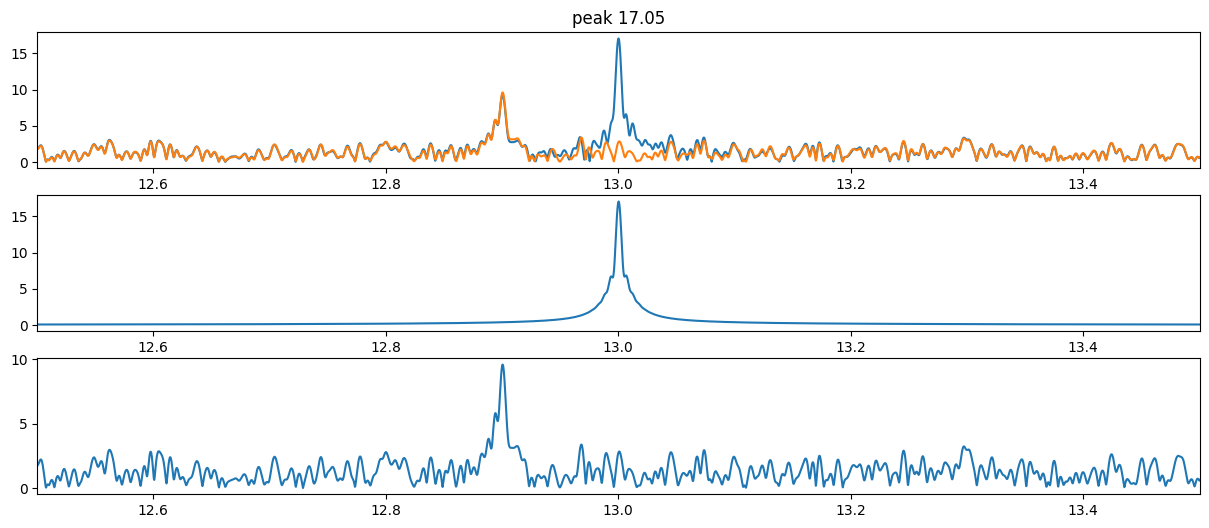

(32.35915771256429, 45.70502501774618) 6.94410732020203e-22 12.900634765625 0


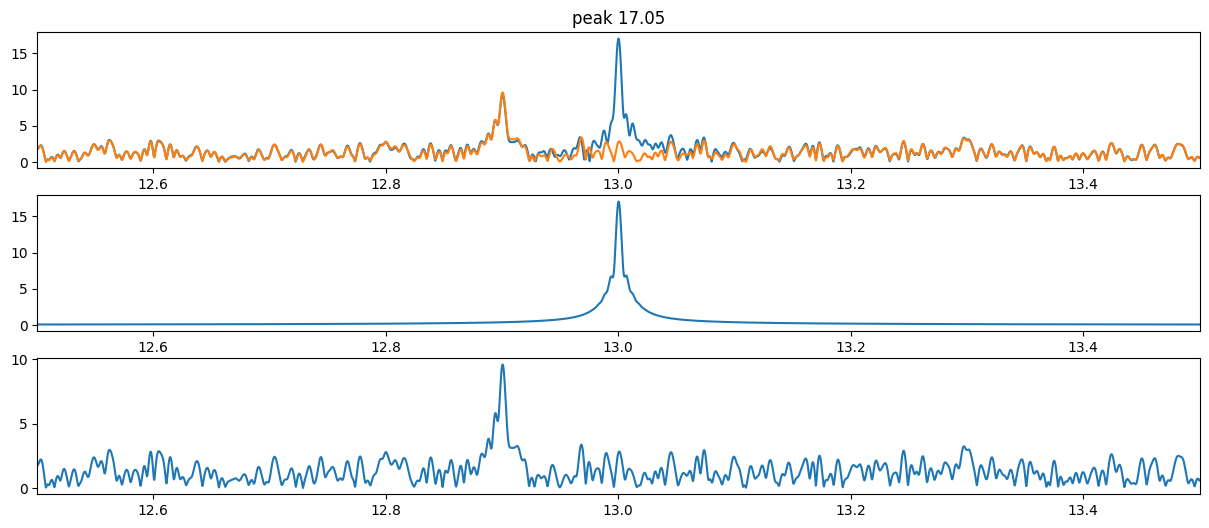

(25.837582057380196, 51.51022952311091) 8.264837110465014e-22 12.900634765625 0


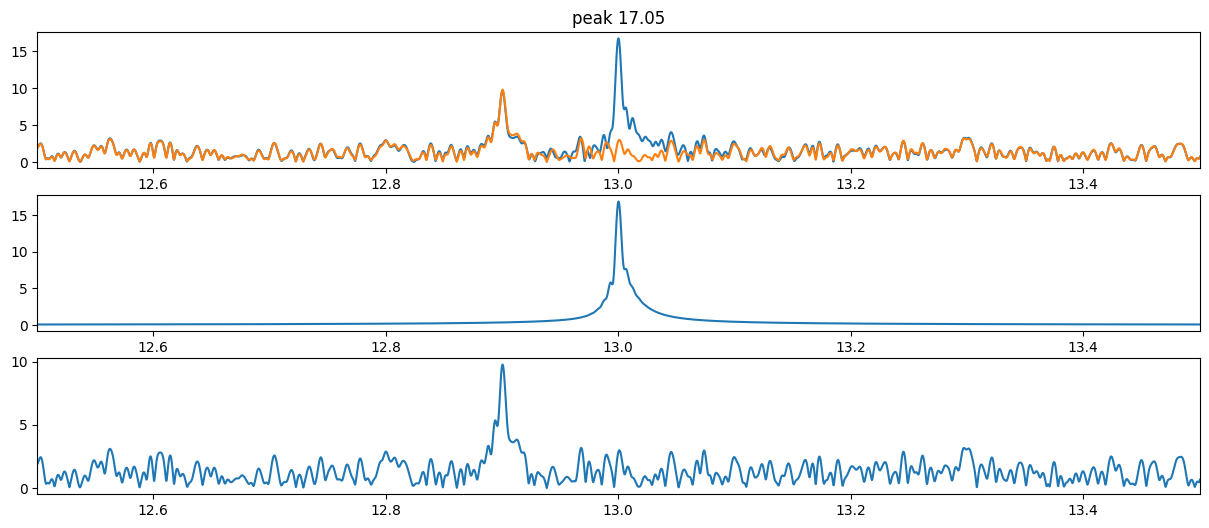

(25.853860818189805, 51.67266623444343) 8.294839505034612e-22 12.900390625 0


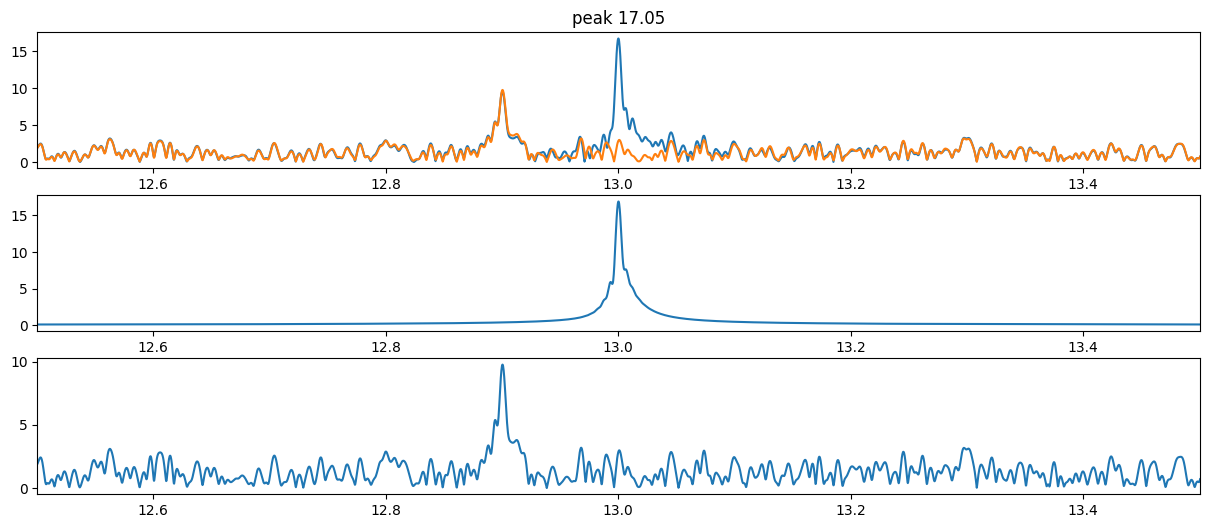

(32.25977866450458, 45.812340334154335) 7.385062122591387e-22 13.00048828125 0


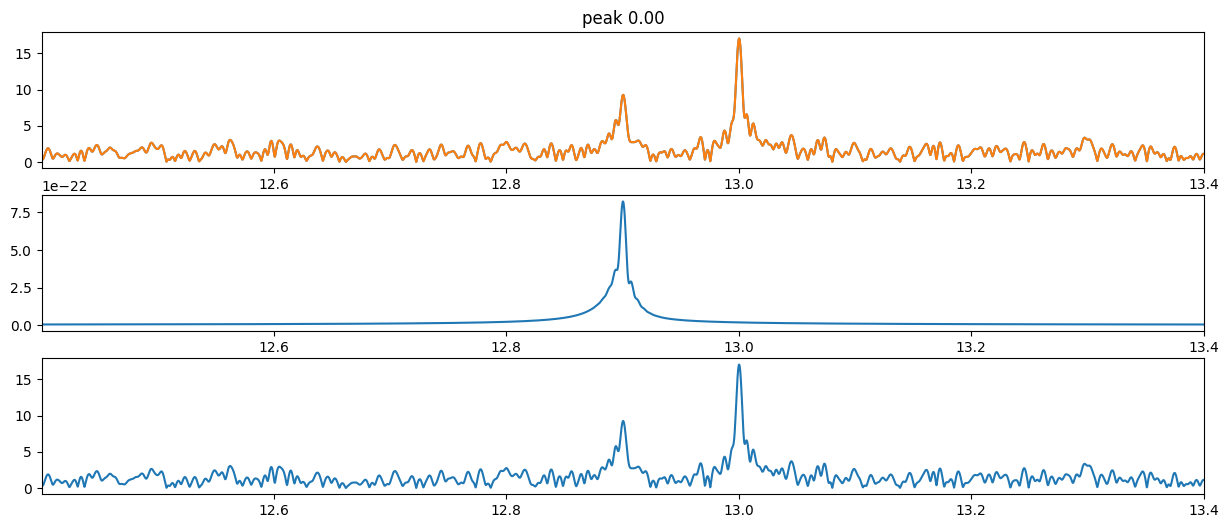

(32.25977866450458, 45.812340334154335) 7.385062122591387e-22 13.00048828125 0


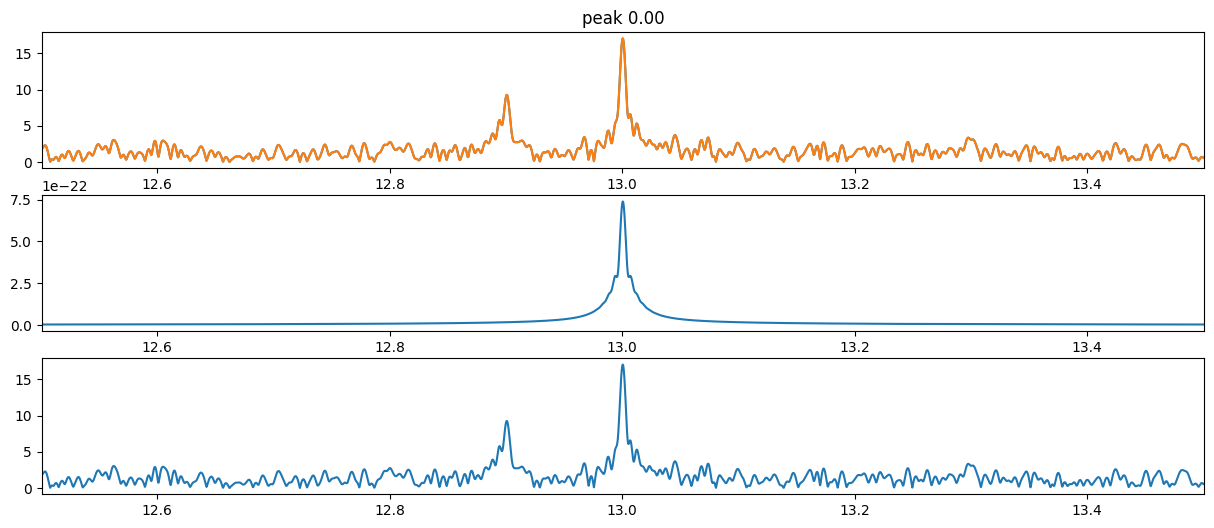

(32.25977866450458, 45.812340334154335) 7.385062122591387e-22 13.00048828125 0


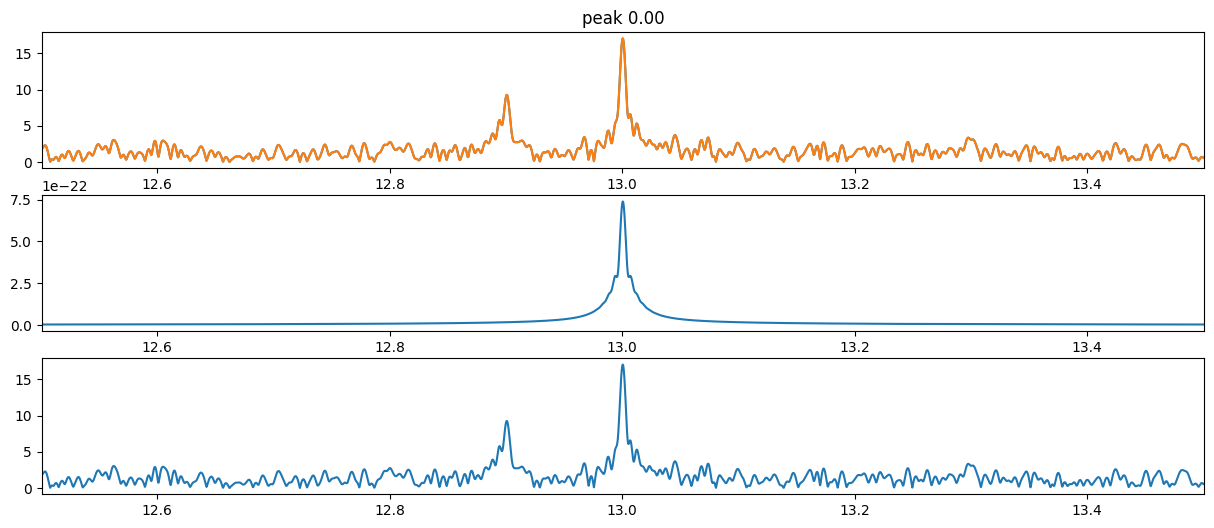

(32.25977866450458, 45.812340334154335) 7.385062122591387e-22 13.00048828125 0


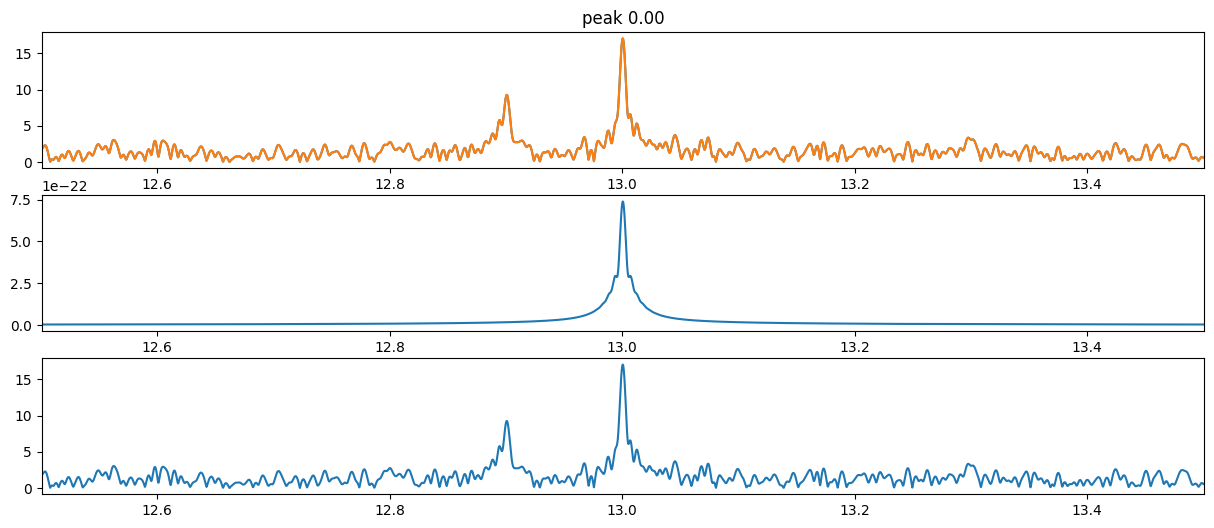

(32.25977866450458, 45.812340334154335) 7.385062122591387e-22 13.00048828125 0


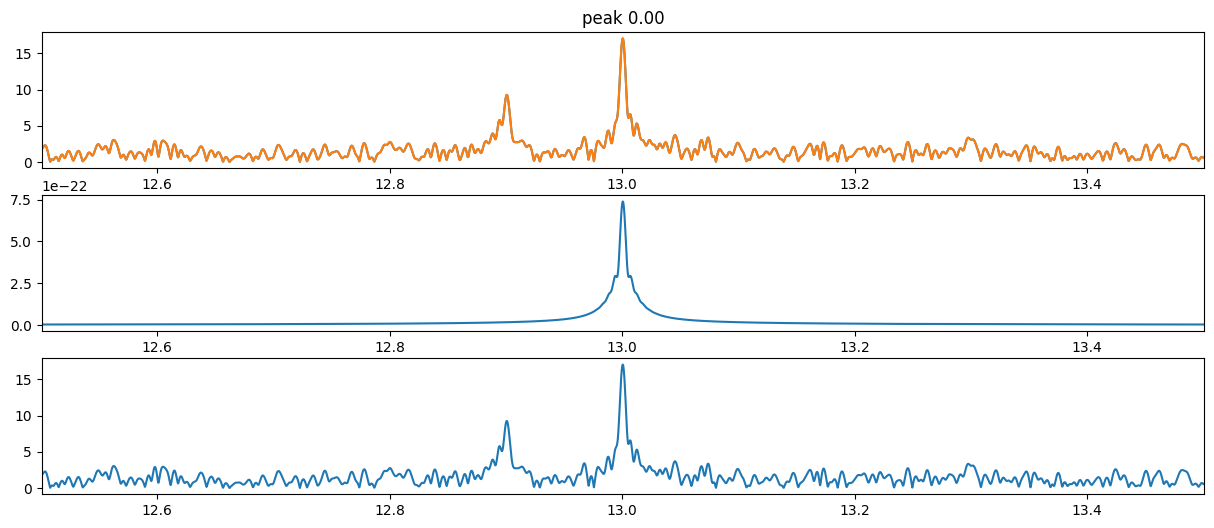

In [4]:
rank = 6 #int(sys.argv[1])
m = 1

for i in range(m*rank, m*(rank+1)):

    m1_bbh = mass1_arr[2*i]
    m2_bbh = mass2_arr[2*i]
    m1_bns = mass1_arr[2*i + 1]
    m2_bns = mass2_arr[2*i + 1]

    h1_bbh = gen_waveform(approximant, m1_bbh, m2_bbh, 0, 0, 1000, 0)
    h1_bns = gen_waveform(approximant, m1_bns, m2_bns, 0, 0, 1000, 0)
    h1_bbh.resize(len(noise))
    h1_bns.resize(len(noise))
    
    snr_desired1 = 15 #int(np.random.randint(low = 6,high = 15,size = 1))
    snr_desired2 = 8 #int(np.random.randint(low = 4,high = 12,size = 1))
    
#     while snr_desired1 <= snr_desired2:
#         snr_desired1 = int(np.random.randint(low=6, high=15, size=1))
#         snr_desired2 = int(np.random.randint(low=4, high=12, size=1))

#     buff = int(np.random.randint(1,50))
    buffer = 0.1
    
    print(m1_bbh,m2_bbh,m1_bns,m2_bns,snr_desired1,snr_desired2,buffer)
    print("----------------------------------------------------------")
    factor1 = snr_desired1/get_optimal_snr(h1_bbh, psd)
    #print(f'factor1: {factor1}, opt_snr1: {get_optimal_snr(h1_bbh, psd)}')
    factor2 = snr_desired2/get_optimal_snr(h1_bns, psd)
    #print(f'factor2: {factor2}, opt_snr1: {get_optimal_snr(h1_bns, psd)}')

    ht_total, _ = overlap((h1_bbh.copy()*factor1), (h1_bns.copy()*factor2), buffer)
    ts1 = inject(ht_total, noise, injtime = inj_time)
    
    R_bank = 0.2
    N_bank =6

    temp_bank = np.append(gen_template_bank(m1_bbh, m2_bbh, R_bank, N_bank//2), 
                 gen_template_bank( m1_bns,  m2_bns, R_bank, N_bank//2), 
                 axis=0)

    bank = preprocess_bank(temp_bank, len(ts1), psd1=psd, approximant=approximant)
    #print('match_filtering...')
    result1 = MF_bank(ts1, bank, psd, show_fig=False, xmin1=35.5, xmax1=36.5)
    itrigger1 = best_trig(result1)
    print(bank[itrigger1]['m1'], bank[itrigger1]['m2'], abs(bank[itrigger1]['csnr_peak']), bank[itrigger1]['tpeak'])
    print("----------------------------------------------------------")
    
    #result = {'trig':[],'index':[],'snr_rec':[], 'snr1':[], 'snr2':[], 'time':[], 'masses_inj':[], 'recovery':[]}  
    result = {'trig':[],'index':[],'snr_rec':[], 'snr1':[], 'snr2':[], 'time':[], 'm1_inj1':[], 'm2_inj1':[], 'm1_inj2':[], 'm2_inj2':[], 'm1_rec':[], 'm2_rec':[]}   

    result["trig"].append('trig1')
    # result["best_trig1"].append(best_trig1)
    # result["best_trig2"].append(best_trig2)
    result["index"].append(itrigger1)
    #result["masses_inj"].append(np.array([m1_bbh, m2_bbh, m1_bns, m2_bns]))
    result['m1_inj1'].append(m1_bbh)
    result['m2_inj1'].append(m2_bbh)
    result['m1_inj2'].append(m1_bns)
    result['m2_inj2'].append(m2_bns)
    result['m1_rec'].append(result1[itrigger1]['m1'])
    result['m2_rec'].append(result1[itrigger1]['m2'])

    #result["recovery"].append((result1[itrigger1]['m1'], result1[itrigger1]['m2']))
    #print(f"mc_bbh_rec {get_chirp_mass(result1[itrigger1]['m1'], result1[itrigger1]['m2'])}")

    # result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
    result["snr_rec"].append(abs(result1[itrigger1]['csnr_peak']))
    result['snr1'].append(snr_desired1)
    result['snr2'].append(snr_desired2)
    result["time"].append(result1[itrigger1]['tpeak'])

    FIGS = True
    for i in range(3):
        # choose best 2nd trigger
        #print(f'loop{i}, finding best trigger (signal 2)')
        itrigger2, max_snr, tpeak2_best, buffer_best, result2 = match_other_best_template_simple(itrigger1, result1, psd, show_figs=FIGS)  # ! <---
        # print("trig2: ", itrigger2, result2[itrigger2]['m1'], result2[itrigger2]['m2'], abs(result2[itrigger2]['csnr_peak']), result2[itrigger2]['tpeak'])
        # print(f"mc_bbh_rec {get_chirp_mass(result2[itrigger2]['m1'], result2[itrigger2]['m2'])}")
        # print('----------------------------------------------------------------------------------------------------')
        # print()
        result["trig"].append('trig2')
        # result["best_trig1"].append(best_trig1)
        # result["best_trig2"].append(best_trig2)
        result["index"].append(itrigger2)
        #result["masses_inj"].append(np.array([m1_bbh, m2_bbh, m1_bns, m2_bns]))
        result['m1_inj1'].append(m1_bbh)
        result['m2_inj1'].append(m2_bbh)
        result['m1_inj2'].append(m1_bns)
        result['m2_inj2'].append(m2_bns)
        result['m1_rec'].append(result2[itrigger2]['m1'])
        result['m2_rec'].append(result2[itrigger2]['m2'])

        #result["recovery"].append((result2[itrigger2]['m1'], result2[itrigger2]['m2']))  # ! <---
        # result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
        result["snr_rec"].append(abs(result2[itrigger2]['csnr_peak']))
        result['snr1'].append(snr_desired1)
        result['snr2'].append(snr_desired2)
        result["time"].append(result2[itrigger2]['tpeak'])

        # adjust 1st trigger
        #print(f'loop{i}, finding best trigger (signal 1)')
        itrigger1, max_snr, tpeak2_best, buffer_best, result1 = match_other_best_template_simple(itrigger2, result2, psd, show_figs=FIGS)  # ! <---
        # print("\t\t\ttrig1: ", itrigger1, result1[itrigger1]['m1'], result1[itrigger1]['m2'], abs(result1[itrigger1]['csnr_peak']), result1[itrigger1]['tpeak'])
        # print(f"mc_bbh_rec {get_chirp_mass(result1[itrigger1]['m1'], result1[itrigger1]['m2'])}")

        # print('----------------------------------------------------------------------------------------------------')
        # print()
        result["trig"].append('trig1')
        # result["best_trig1"].append(best_trig1)
        # result["best_trig2"].append(best_trig2)
        result["index"].append(itrigger1)
        #result["masses_inj"].append(np.array([m1_bbh, m2_bbh, m1_bns, m2_bns]))
        result['m1_inj1'].append(m1_bbh)
        result['m2_inj1'].append(m2_bbh)
        result['m1_inj2'].append(m1_bns)
        result['m2_inj2'].append(m2_bns)
        result['m1_rec'].append(result1[itrigger1]['m1'])
        result['m2_rec'].append(result1[itrigger1]['m2'])

        #result["recovery"].append((result1[itrigger1]['m1'], result1[itrigger1]['m2']))  # ! <---

        # result["best_recovery"].append((mass1_bank[best_trig1], mass2_bank[best_trig1],mass1_bank[best_trig2], mass2_bank[best_trig2]))
        result["snr_rec"].append(abs(result1[itrigger1]['csnr_peak']))
        result['snr1'].append(snr_desired1)
        result['snr2'].append(snr_desired2)
        result["time"].append(result1[itrigger1]['tpeak'])

        data = pd.DataFrame.from_dict(result)
        data.to_csv('sub_alg_%d.csv'%rank)

In [5]:
bank

[{'m1': 32.25977866450458,
  'm2': 45.812340334154335,
  'template': <pycbc.types.timeseries.TimeSeries at 0x7f05c60e8e50>,
  'snr': <pycbc.types.timeseries.TimeSeries at 0x7f05c95625f0>,
  'tpeak': 13.00048828125,
  'csnr_peak': 7.385062122591387e-22},
 {'m1': 32.45174097505369,
  'm2': 45.77231208378314,
  'template': <pycbc.types.timeseries.TimeSeries at 0x7f05c9562590>,
  'snr': <pycbc.types.timeseries.TimeSeries at 0x7f05c9563e80>,
  'tpeak': 13.000244140625,
  'csnr_peak': 7.360731730696788e-22},
 {'m1': 32.35915771256429,
  'm2': 45.70502501774618,
  'template': <pycbc.types.timeseries.TimeSeries at 0x7f05c60ea470>,
  'snr': <pycbc.types.timeseries.TimeSeries at 0x7f05c60eaa70>,
  'tpeak': 13.00048828125,
  'csnr_peak': 7.380191439180716e-22},
 {'m1': 25.837582057380196,
  'm2': 51.51022952311091,
  'template': <pycbc.types.timeseries.TimeSeries at 0x7f05c60eac80>,
  'snr': <pycbc.types.timeseries.TimeSeries at 0x7f05c60eab00>,
  'tpeak': 13.000244140625,
  'csnr_peak': 6.824444